# LQR for pendulum + Regions of Attraction

In [1]:
import numpy as np
from darli.models import RobotModel

In [2]:
urdf_file = 'model/double_pendulum.urdf'
model = RobotModel(urdf_file)

In [3]:
nq, nv, nu = model.nq, model.nv, model.nu
nq, nv, nu

(2, 2, 2)

In [4]:
q_des_np = np.array([np.pi, 0])
q_dot_des_np = np.array([0, 0]) 
state_des_np = np.concatenate([q_des_np, q_dot_des_np])

u_des_np = np.zeros(2)

In [5]:
A = np.array(model.state_space.state_jacobian(state_des_np, u_des_np))
B = np.array(model.state_space.input_jacobian(state_des_np, u_des_np))

In [6]:
A, B

(array([[  0.        ,   0.        ,   1.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,   1.        ],
        [ 19.85625223, -19.18019767,   0.        ,   0.        ],
        [-20.09394054,  58.21624743,  -0.        ,  -0.        ]]),
 array([[ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 3.70162861, -7.42575805],
        [-7.42575805, 18.72933505]]))

In [7]:
dt_control = 1e-2

In [8]:
Ad, Bd = np.eye(nq + nv) + dt_control*A, dt_control*B

In [9]:
from scipy.linalg import solve_discrete_are as dare

def dlqr(A, B, Q, R):
    '''Discrete time LTI LQR'''
    # Solve discrete Ricatti equation (DARE)
    P = dare(A, B, Q, R)
    # Compute the LQR gain
    K = np.linalg.inv(B.T @ P @ B + R) @ (B.T @ P @ A)
    return K, P

In [10]:
Q = np.eye(nq + nv)
R = np.eye(nu)*0.1
K, P = dlqr(Ad, Bd, Q, R)
# print(K)

In [11]:
import mujoco
import mediapy as media

%env MUJOCO_GL=egl

env: MUJOCO_GL=egl


In [12]:
mj_model = mujoco.MjModel.from_xml_path("model/scene.xml")
data = mujoco.MjData(mj_model)
dt_mj = 1e-3
mj_model.opt.timestep = dt_mj

renderer = mujoco.Renderer(mj_model)
scene_option = mujoco.MjvOption()

""

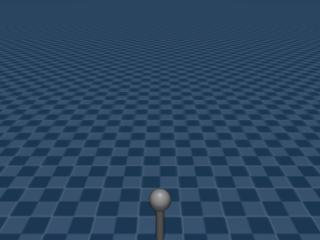

In [13]:
mujoco.mj_forward(mj_model, data)
renderer.update_scene(data, camera="closeup")

media.show_image(renderer.render())

In [14]:
duration = 5  # (seconds)
framerate = 30 # used just for visualization

# Simulate and display video.
frames = []
mujoco.mj_resetData(mj_model, data)  # Reset state and time.

data.qpos = np.array(0)

state_history = []
control_history = []
error_history = []


while data.time < duration:
    # TODO: your control should be inserted
    q_mj, q_dot_mj = data.qpos.copy(), data.qvel.copy(),  
    state_mj = np.hstack((q_mj, q_dot_mj))
    u_mj =  -K @(state_mj - state_des_np) + u_des_np
    data.ctrl = np.array(u_mj).reshape(model.nu, )
    state_history.append(state_mj)
    error_history.append(state_mj - state_des_np)
    control_history.append(data.ctrl.copy())    

    mujoco.mj_step(mj_model, data)

    if len(frames) < data.time * framerate:
        renderer.update_scene(data, scene_option=scene_option, camera="closeup")
        pixels = renderer.render()
        frames.append(pixels)
    
media.show_video(frames, fps=framerate)

In [15]:
import matplotlib.pyplot as plt

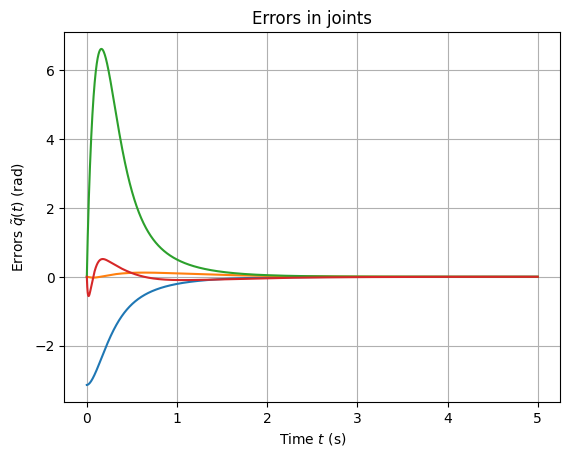

In [16]:
ns = len(state_history)
t = np.linspace(0, duration, ns)

plt.title(r'Errors in joints')
plt.plot(t, np.array(error_history)[:,:6])
plt.grid(True)
plt.ylabel(r'Errors $\tilde{q}(t)$ (rad)')
plt.xlabel(r'Time $t$ (s)')
plt.show()

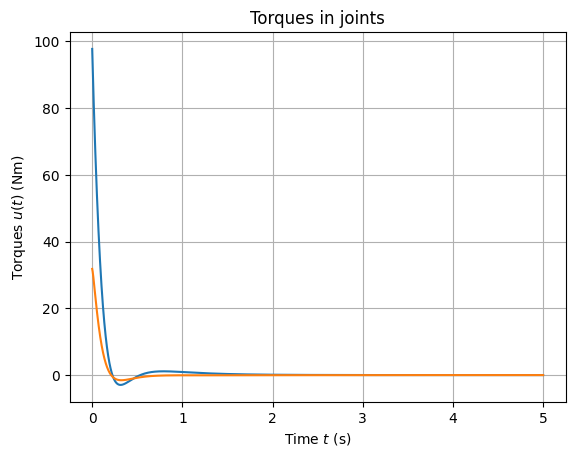

In [17]:

plt.title(r'Torques in joints')
plt.plot(t, np.array(control_history))#,'r', linewidth=2.0)
plt.grid(True)
plt.ylabel(r'Torques $u(t)$ (Nm)')
plt.xlabel(r'Time $t$ (s)')
plt.show()

## Regions of Attraction

Let's also visualize the Regions of Attraction for the LQR controller. For that, let's consider:
$$V(x) = \frac{1}{2} x^T P x$$
and try to find RoA.

In [18]:
def discrete_sampling_roa(V, x_bounds, N=1000):
    x_min, x_max = x_bounds
    x_range = np.array(x_max) - np.array(x_min)
    n = np.shape(x_min)[0]

    c = np.inf
    ct = []

    for i in range(N):
        x_i = x_min + x_range*np.random.rand(n)
        V_i = V(x_i)
        if V_i <= c:
            dV_i = V(x_i * 1.01) - V_i
            if dV_i >= 0:
                c = V_i
                ct.append(c)  
    return c, ct

In [19]:
V_func = lambda x: x.T @ P @ x 
x_min_np = -np.pi*np.ones(model.nq+model.nv)
x_max_np = np.pi*np.ones(model.nq+model.nv)
c, _ = discrete_sampling_roa(V_func, (x_min_np, x_max_np))

## Dual Faceted Linearization

In [20]:
import casadi as cs

The dynamics of double pendulum could be described as:
$$M\ddot{q} + C(q, \dot{q})\dot{q} = \tau_g(q) + Bu$$

where:
$$
\begin{align*} M(q) =&
\begin{bmatrix} (m_1 + m_2)l_1^2 + m_2 l_2^2 + 2 m_2 l_1l_2 c_2 & m_2 l_2^2
+ m_2 l_1 l_2 c_2 \\ m_2 l_2^2 + m_2 l_1 l_2 c_2 & m_2 l_2^2 \end{bmatrix}
\\ C(q,\dot{q}) =& \begin{bmatrix} 0 & -m_2 l_1 l_2 (2\dot{q}_1 +
\dot{q}_2)s_2 \\ \frac{1}{2} m_2 l_1 l_2 (2\dot{q}_1 + \dot{q}_2) s_2 &
-\frac{1}{2}m_2 l_1 l_2 \dot{q}_1 s_2 \end{bmatrix} \\ \tau_g(q) =& -g
\begin{bmatrix} (m_1 + m_2) l_1 s_1 + m_2 l_2 s_{1+2} \\ m_2 l_2 s_{1+2}
\end{bmatrix} , \quad B = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}
\end{align*}$$

Let's bring it to the DFL form:
$$\dot{x} = A_x x + A_\eta \eta + B u

### Sympy expression analysis, draft

In [21]:
from sympy.physics.vector import dynamicsymbols
import sympy as sp

m1, m2, l1, l2, g = sp.symbols('m_1 m_2 l_1 l_2 g')
q1, q2 = dynamicsymbols('q_1 q_2')
dq1, dq2 = q1.diff(), q2.diff()

q = sp.Matrix([q1, q2])
dq = sp.Matrix([dq1, dq2])

M = sp.Matrix([
    [(m1 + m2)*l1**2 + m2*l2**2 + 2*m2*l1*l2*sp.cos(q2), m2*l2**2 + m2*l1*l2*sp.cos(q2)], 
    [m2*l2**2 + m2*l1*l2*sp.cos(q2), m2*l2**2]
])

C = sp.Matrix([
    [0, -m2*l1*l2*(2*dq1 + dq2)*sp.sin(q2)],
    [m2*l1*l2*(2*dq1 + dq2)*sp.sin(q2)/2, -m2*l1*l2*dq1*sp.sin(q2)/2]
])

tau = - sp.Matrix([
    (m1 + m2) * l1 * sp.sin(q1) + m2 * l2 * sp.sin(q1 + q2),
    m2 * l2 * sp.sin(q1 + q2)
]) * g

B = sp.eye(2)

In [22]:
M_inv = M.inv()

In [24]:
M_inv @ C

Matrix([
[                                                               l_1*l_2*m_2*(l_1*cos(q_2(t)) + l_2)*(2*Derivative(q_1(t), t) + Derivative(q_2(t), t))*sin(q_2(t))/(2*(-l_1**2*l_2*m_1 + l_1**2*l_2*m_2*cos(q_2(t))**2 - l_1**2*l_2*m_2)),                                                                                                    -l_1*l_2*m_2*(l_1*cos(q_2(t)) + l_2)*sin(q_2(t))*Derivative(q_1(t), t)/(2*(-l_1**2*l_2*m_1 + l_1**2*l_2*m_2*cos(q_2(t))**2 - l_1**2*l_2*m_2)) + l_1*l_2*m_2*(2*Derivative(q_1(t), t) + Derivative(q_2(t), t))*sin(q_2(t))/(-l_1**2*m_1 + l_1**2*m_2*cos(q_2(t))**2 - l_1**2*m_2)],
[l_1*l_2*m_2*(2*Derivative(q_1(t), t) + Derivative(q_2(t), t))*(-l_1**2*m_1 - l_1**2*m_2 - 2*l_1*l_2*m_2*cos(q_2(t)) - l_2**2*m_2)*sin(q_2(t))/(2*(-l_1**2*l_2**2*m_1*m_2 + l_1**2*l_2**2*m_2**2*cos(q_2(t))**2 - l_1**2*l_2**2*m_2**2)), -l_1*l_2*m_2*(l_1*cos(q_2(t)) + l_2)*(2*Derivative(q_1(t), t) + Derivative(q_2(t), t))*sin(q_2(t))/(-l_1**2*l_2*m_1 + l_1**2*l_2*m_2*cos(q_2(t))**2 -

In [25]:
M_inv @ tau

Matrix([
[                                                                                                   -g*l_2*m_2*(l_1*cos(q_2(t)) + l_2)*sin(q_1(t) + q_2(t))/(-l_1**2*l_2*m_1 + l_1**2*l_2*m_2*cos(q_2(t))**2 - l_1**2*l_2*m_2) - g*(-l_1*(m_1 + m_2)*sin(q_1(t)) - l_2*m_2*sin(q_1(t) + q_2(t)))/(-l_1**2*m_1 + l_1**2*m_2*cos(q_2(t))**2 - l_1**2*m_2)],
[-g*l_2*m_2*(-l_1**2*m_1 - l_1**2*m_2 - 2*l_1*l_2*m_2*cos(q_2(t)) - l_2**2*m_2)*sin(q_1(t) + q_2(t))/(-l_1**2*l_2**2*m_1*m_2 + l_1**2*l_2**2*m_2**2*cos(q_2(t))**2 - l_1**2*l_2**2*m_2**2) + g*(l_1*cos(q_2(t)) + l_2)*(-l_1*(m_1 + m_2)*sin(q_1(t)) - l_2*m_2*sin(q_1(t) + q_2(t)))/(-l_1**2*l_2*m_1 + l_1**2*l_2*m_2*cos(q_2(t))**2 - l_1**2*l_2*m_2)]])

In [26]:
M_inv @ tau - M_inv @ C @ dq

Matrix([
[                                                                                                                                                                                                                                                                     -g*l_2*m_2*(l_1*cos(q_2(t)) + l_2)*sin(q_1(t) + q_2(t))/(-l_1**2*l_2*m_1 + l_1**2*l_2*m_2*cos(q_2(t))**2 - l_1**2*l_2*m_2) - g*(-l_1*(m_1 + m_2)*sin(q_1(t)) - l_2*m_2*sin(q_1(t) + q_2(t)))/(-l_1**2*m_1 + l_1**2*m_2*cos(q_2(t))**2 - l_1**2*m_2) - l_1*l_2*m_2*(l_1*cos(q_2(t)) + l_2)*(2*Derivative(q_1(t), t) + Derivative(q_2(t), t))*sin(q_2(t))*Derivative(q_1(t), t)/(2*(-l_1**2*l_2*m_1 + l_1**2*l_2*m_2*cos(q_2(t))**2 - l_1**2*l_2*m_2)) - (-l_1*l_2*m_2*(l_1*cos(q_2(t)) + l_2)*sin(q_2(t))*Derivative(q_1(t), t)/(2*(-l_1**2*l_2*m_1 + l_1**2*l_2*m_2*cos(q_2(t))**2 - l_1**2*l_2*m_2)) + l_1*l_2*m_2*(2*Derivative(q_1(t), t) + Derivative(q_2(t), t))*sin(q_2(t))/(-l_1**2*m_1 + l_1**2*m_2*cos(q_2(t))**2 - l_1**2*m_2))*Derivative(q_2(

### Choice of $\eta$

In [27]:
q_cs = model._q
v_cs = model._v
v_dot_cs = model._dv
u_cs = model._u

state_cs = cs.vertcat(q_cs, v_cs)

For the sake of simplicity, let's assume that our 

In [28]:
# Option 1: least eta size
# M_inv = cs.inv(model.inertia(q_cs))

# eta1_cs = M_inv @ model.coriolis(q_cs, v_cs)
# eta2_cs = M_inv @ model.gravity(q_cs)
# eta_cs_list = [eta1_cs, eta2_cs]

# A_eta_idxs = [(0, 0), (1, 1), (0, 2), (1, 3)]

In [29]:
# Option 2: elementwise decomposition
M_inv = cs.inv(model.inertia(q_cs))
coriolis_matrix = model.coriolis_matrix(q_cs, v_cs)
gravity = model.gravity(q_cs)

eta_cs_list = []
A_eta_idxs = []

# Term M_inv @ model.coriolis_matrix(q_cs, v_cs) @ v_cs
for m_row in range(M_inv.size1()):
    for m_col in range(M_inv.size2()):
        for c_col in range(coriolis_matrix.size2()):
            n_elems = len(eta_cs_list)
            eta_cs_list.append(
                M_inv[m_row, m_col] @ coriolis_matrix[m_col, c_col] @ v_cs[c_col]
            )
            A_eta_idxs.append((m_row, n_elems,))

# Term M_inv @ model.gravity(q_cs)
for m_row in range(M_inv.size1()):
    for m_col in range(M_inv.size2()):
        n_elems = len(eta_cs_list)
        eta_cs_list.append(
            M_inv[m_row, m_col] @ gravity[m_col]
        )
        A_eta_idxs.append((m_row, n_elems,))

In [ ]:
# Option 3: impulse equation


In [30]:
eta_cs = cs.vertcat(*eta_cs_list)
n_eta = eta_cs.size1()

A_x_np = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
])

A_eta_np = np.zeros((nq+nv, n_eta))
for (row, col) in A_eta_idxs:
    A_eta_np[nq+row, col] = -1

B_np = np.array([
    [0, 0],
    [0, 0],
    [1, 0],
    [0, 1],
])

A_x_cs = cs.SX(A_x_np)
A_eta_cs = cs.SX(A_eta_np)
B_cs = cs.SX(B_np)

eta_cs_fn = cs.Function(
    'eta',
    [q_cs, v_cs],
    [
        eta_cs
    ]
)
eta_cs_fn

Function(eta:(i0[2],i1[2])->(o0[12]) SXFunction)

In [31]:
M_inv = cs.inv(model.inertia(q_cs))
M_inv_aug = cs.SX.eye(nq+nv)
M_inv_aug[-nv:, -nv:] = M_inv

In [32]:
F1 = cs.Function('F1', [q_cs, v_cs, u_cs], [A_x_cs @ cs.vertcat(q_cs, v_cs) + A_eta_cs @ eta_cs_fn(q_cs, v_cs) + M_inv_aug @ B_cs @ u_cs])

q_rand, v_rand, u_rand = np.random.uniform(-1, 1, size=(2, )), np.random.uniform(-1, 1, size=(2, )), np.random.uniform(-1, 1, size=(2, ))

rand_dyn_dfl = np.array(F1(q_rand, v_rand, u_rand))
rand_dyn_dfl

array([[  0.40090123],
       [  0.72715039],
       [-21.52923622],
       [ 28.45605439]])

In [33]:
rand_dyn_pin = np.array(model.forward_dynamics(q_rand, v_rand, u_rand))
rand_dyn_pin

array([[-21.67774859],
       [ 28.77054984]])

## Data collection

In [34]:
dataset = {
    'q0': [],
    'q1': [],
    'v0': [],
    'v1': [],
    'v_dot0': [],
    'v_dot1': [],
    'u0': [],
    'u1': []
}

""

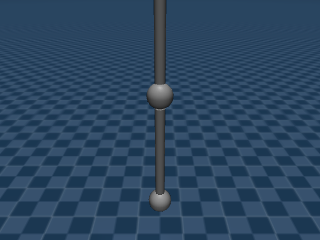

In [35]:
try:
    mujoco.mj_forward(mj_model, data)
    renderer.update_scene(data, camera="closeup")

    media.show_image(renderer.render())
except:
    mj_model = mujoco.MjModel.from_xml_path("model/scene.xml")
    data = mujoco.MjData(mj_model)
    dt_mj = 1e-3
    mj_model.opt.timestep = dt_mj

    renderer = mujoco.Renderer(mj_model)
    scene_option = mujoco.MjvOption()

In [36]:
duration = 100  # (seconds)
dt_control = 1e-1
last_control_inj = 0

# Simulate and display video.
frames = []
mujoco.mj_resetData(mj_model, data)  # Reset state and time.

data.qpos = np.array(0)

state_history = []
control_history = []
error_history = []

while data.time < duration:
    # TODO: your control should be inserted
    q_mj, q_dot_mj = data.qpos.copy(), data.qvel.copy(),  
    state = np.hstack((q_mj, q_dot_mj))
    if data.time > last_control_inj + dt_control:
        last_control_inj = data.time
        u_mj = np.random.uniform(-1, 1, size=(2, ))
    
    data.ctrl = u_mj
    for i in range(nq):
        dataset[f'q{i}'].append(q_mj[i])
        dataset[f'v{i}'].append(q_dot_mj[i])
        dataset[f'u{i}'].append(u_mj[i]) 
    control_history.append(data.ctrl.copy())    

    mujoco.mj_step(mj_model, data)
    for i in range(nq):
        dataset[f'v_dot{i}'].append(data.qacc.copy()[i])

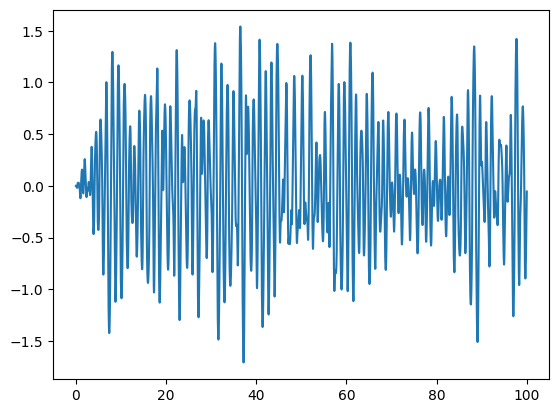

In [37]:
plt.plot(np.arange(0, duration, dt_mj), dataset['q0'])

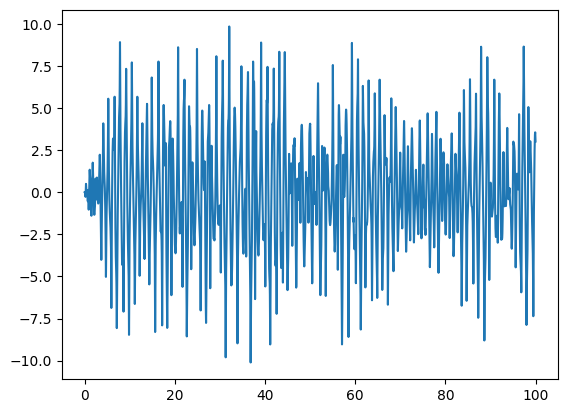

In [38]:
plt.plot(np.arange(0, duration, dt_mj), dataset['v0'])

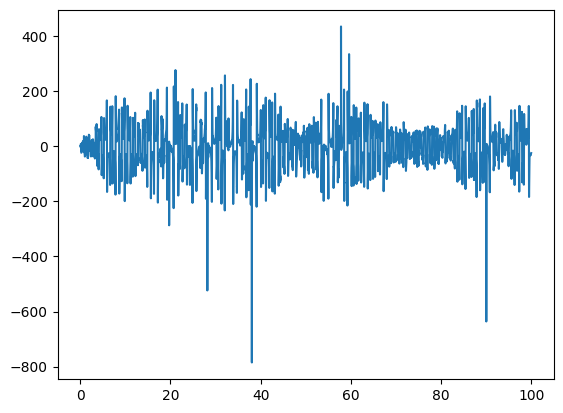

In [39]:
plt.plot(np.arange(0, duration, dt_mj), dataset['v_dot1'])

In [40]:
import pandas as pd

df = pd.DataFrame(dataset)
df.to_csv('dataset.csv')

## Fitting the DFL dynamics

In [41]:
import pandas as pd

dataset = pd.read_csv('dataset.csv', index_col=0)
dataset.head()

,q0,q1,v0,v1,v_dot0,v_dot1,u0,u1
0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.006637,-0.017597,0.000456,-0.000393
1,6.637417e-09,-1.759674e-08,0.000007,-0.000018,0.006637,-0.017595,0.000456,-0.000393
2,1.991172e-08,-5.278877e-08,0.000013,-0.000035,0.006636,-0.017592,0.000456,-0.000393
3,3.982185e-08,-1.055732e-07,0.000020,-0.000053,0.006634,-0.017588,0.000456,-0.000393
4,6.636621e-08,-1.759456e-07,0.000027,-0.000070,0.006632,-0.017582,0.000456,-0.000393


In [42]:
q_np = np.array(dataset.loc[:, ['q0', 'q1']])
v_np = np.array(dataset.loc[:, ['v0', 'v1']])
state_np = np.concatenate([q_np, v_np], axis=1)
v_dot_np = np.array(dataset.loc[:, ['v_dot0', 'v_dot1']])
state_dot_np = np.concatenate([v_np, v_dot_np], axis=1)
u_np = np.array(dataset.loc[:, ['u0', 'u1']])

state_cs = cs.vertcat(q_cs, v_cs)
state_dot_cs = cs.vertcat(v_cs, v_dot_cs)

In [43]:
eta_dot_cs_fn = cs.Function(
    "eta_dot", 
    [q_cs, state_dot_cs], 
    [
        cs.jacobian(eta_cs_fn(q_cs, v_cs), state_cs) @ state_dot_cs
    ]
)
eta_dot_cs_fn 

Function(eta_dot:(i0[2],i1[4])->(o0[12]) SXFunction)

In [44]:
eta_np = np.array([
    eta_cs_fn(q_np_i, v_np_i) 
    for q_np_i, v_np_i in zip(q_np, v_np)
])[:, :, 0]

In [45]:
eta_dot_np = np.array([
    eta_dot_cs_fn(q_np_i, state_dot_np_i) 
    for q_np_i, state_dot_np_i in zip(q_np, state_dot_np)
])[:, :, 0]
eta_dot_cs = cs.SX(eta_dot_np)

In [46]:
full_state_np = np.concatenate([state_np, eta_np, u_np], axis=1)
full_state_cs = cs.SX(full_state_np)

In [47]:
H_np = np.random.uniform(-5, 5, size=(n_eta, nq + nv + n_eta + nu))
H_cs = cs.SX.sym('H', n_eta, nq + nv + n_eta + nu)
H_cs

SX(
[[H_0, H_12, H_24, H_36, H_48, H_60, H_72, H_84, H_96, H_108, H_120, H_132, H_144, H_156, H_168, H_180, H_192, H_204], 
 [H_1, H_13, H_25, H_37, H_49, H_61, H_73, H_85, H_97, H_109, H_121, H_133, H_145, H_157, H_169, H_181, H_193, H_205], 
 [H_2, H_14, H_26, H_38, H_50, H_62, H_74, H_86, H_98, H_110, H_122, H_134, H_146, H_158, H_170, H_182, H_194, H_206], 
 [H_3, H_15, H_27, H_39, H_51, H_63, H_75, H_87, H_99, H_111, H_123, H_135, H_147, H_159, H_171, H_183, H_195, H_207], 
 [H_4, H_16, H_28, H_40, H_52, H_64, H_76, H_88, H_100, H_112, H_124, H_136, H_148, H_160, H_172, H_184, H_196, H_208], 
 [H_5, H_17, H_29, H_41, H_53, H_65, H_77, H_89, H_101, H_113, H_125, H_137, H_149, H_161, H_173, H_185, H_197, H_209], 
 [H_6, H_18, H_30, H_42, H_54, H_66, H_78, H_90, H_102, H_114, H_126, H_138, H_150, H_162, H_174, H_186, H_198, H_210], 
 [H_7, H_19, H_31, H_43, H_55, H_67, H_79, H_91, H_103, H_115, H_127, H_139, H_151, H_163, H_175, H_187, H_199, H_211], 
 [H_8, H_20, H_32, H_44, H_56, H

In [48]:
(H_cs @ full_state_cs.T).shape

(12, 100000)

In [49]:
eta_dot_cs.shape

(100000, 12)

In [50]:
H_cs.size()

(12, 18)

In [51]:
import cvxpy as cp

In [52]:
H_w_cp = cp.Variable((n_eta, nq + nv + n_eta + nu))
objective_samples = 1/len(full_state_np) * cp.sum_squares(eta_dot_np.T - H_w_cp@full_state_np.T)
problem_samples = cp.Problem(cp.Minimize(objective_samples))
problem_samples.solve(solver=cp.OSQP)

H_w_np = H_w_cp.value

## Visualization

""

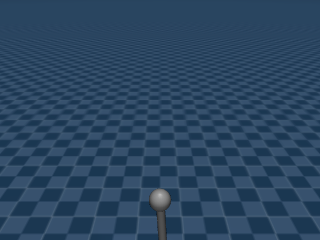

In [53]:
try:
    mujoco.mj_forward(mj_model, data)
    renderer.update_scene(data, camera="closeup")

    media.show_image(renderer.render())
except:
    mj_model = mujoco.MjModel.from_xml_path("model/scene.xml")
    data = mujoco.MjData(mj_model)
    dt_mj = 1e-3
    mj_model.opt.timestep = dt_mj

    renderer = mujoco.Renderer(mj_model)
    scene_option = mujoco.MjvOption()

In [54]:
duration = 10  # (seconds)
dt_control = 1e-1
last_control_inj = 0

# Simulate and display video.
frames = []
mujoco.mj_resetData(mj_model, data)  # Reset state and time.

data.qpos = np.random.uniform(-np.pi, np.pi, size=(nq, ))

state_history = []
control_history = []
error_history = []
time_history = []

while data.time < duration:
    q_mj, q_dot_mj = data.qpos.copy(), data.qvel.copy(),  
    state = np.hstack((q_mj, q_dot_mj))
    
    if data.time > last_control_inj + dt_control:
        last_control_inj = data.time
        u_mj = np.random.uniform(-1, 1, size=(2, ))
    
    data.ctrl = u_mj
    mujoco.mj_step(mj_model, data)
    
    time_history.append(data.time)
    state_history.append(state)    
    control_history.append(u_mj)

In [55]:
state_history_np = np.array(state_history)[:-1]
control_history_np = np.array(control_history)[:-1]
time_history_np = np.array(time_history)[:-1]

eta_history_np = np.array([
    eta_cs_fn(state_i[:2], state_i[2:]) 
    for state_i in state_history_np
])[:, :, 0]

In [56]:
time_history_np.shape

(10000,)

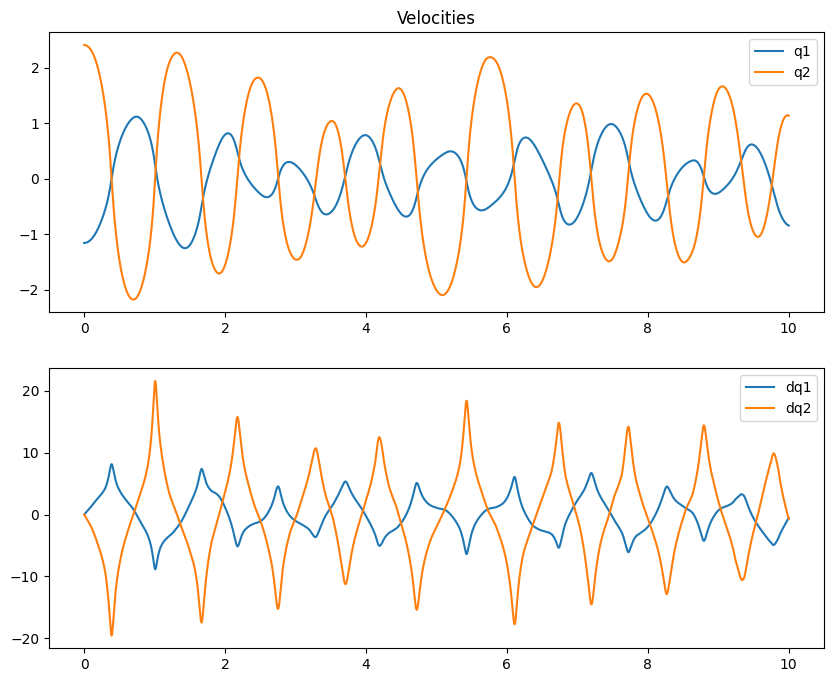

In [57]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
ax[0].plot(time_history_np, state_history_np[:, :2], label=["q1", "q2"])
ax[0].set_title('Positions')
ax[0].legend()
ax[1].plot(time_history_np, state_history_np[:, 2:], label=["dq1", "dq2"])
ax[0].set_title('Velocities')
ax[1].legend()
plt.show()

In [58]:
len(control_history_np)

10000

In [61]:
from scipy.integrate import solve_ivp

def f_subs(t, x, n_eta, tau, A_x, A_eta, B, H_w):
    state, eta = x[:-n_eta], x[-n_eta:]
    full_state = np.concatenate((state, eta, tau))
    M_inv_np = np.array(cs.inv(model.inertia(state[:nq])))
    M_aug_np = np.eye(nq+nv)
    M_aug_np[-nv:, -nv:] = M_inv_np
    state_dot = A_x @ state + A_eta @ eta + M_aug_np @ B @ tau
    eta_dot = H_w @ full_state

    return np.concatenate([state_dot, eta_dot])

cur_x = np.concatenate([state_history_np[0], eta_history_np[0]])
linearized_state_history = []
linearized_eta_history = []
cur_t = time_history_np[0]
tau_idx = 0
while cur_t < duration:
    t_end = cur_t + dt_control
    tau_i = control_history_np[tau_idx]
    
    sol = solve_ivp(
        f_subs, 
        (cur_t, t_end), 
        cur_x, 
        t_eval=np.linspace(cur_t, t_end, int(dt_control/dt_mj)), 
        args=(n_eta, tau_i, A_x_np, A_eta_np, B_np, H_w_np)
    )
    linearized_state_history.append(sol.y.T[:, :nq+nv])
    linearized_eta_history.append(sol.y.T[:, nq+nv:])
    
    cur_x = sol.y[:, -1]
    cur_t = t_end
    tau_idx += 1

In [62]:
linearized_state_history_np = np.concatenate(linearized_state_history, axis=0)
linearized_eta_history_np = np.concatenate(linearized_eta_history, axis=0)

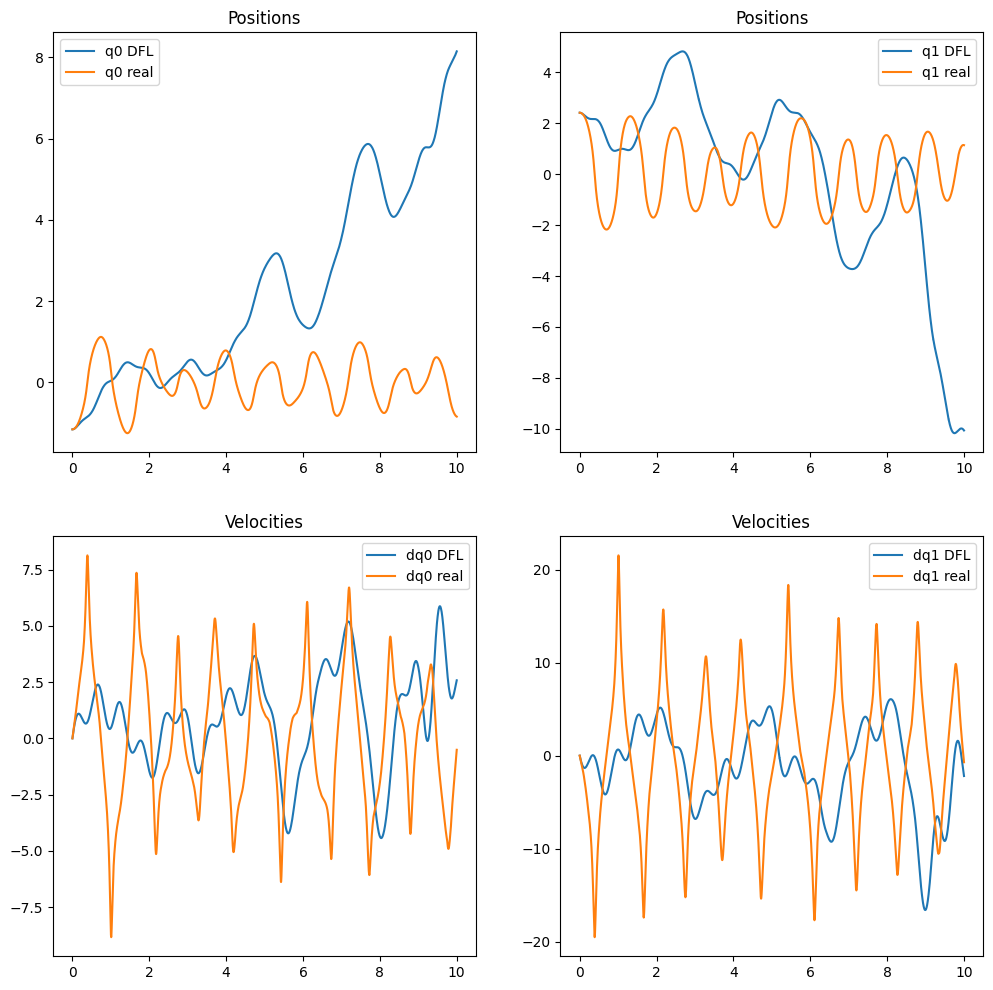

In [63]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
for i in range(2):
    ax[0, i].plot(time_history_np, linearized_state_history_np[:, i], label=f"q{i} DFL")
    ax[0, i].set_title('Positions')
    ax[0, i].plot(time_history_np, state_history_np[:, i], label=f"q{i} real")
    ax[0, i].legend()
    ax[1, i].plot(time_history_np, linearized_state_history_np[:, i+2], label=f"dq{i} DFL")
    ax[1, i].plot(time_history_np, state_history_np[:, i+2], label=f"dq{i} real")
    ax[1, i].set_title('Velocities')
    ax[1, i].legend()
plt.show()